# Galaxy prediction with CNNs

Main Goal: build a convolutional neural network (CNN) and try to achieve the highest accuracy possible on the test set

## Import relevant packages and initialize

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset

plt.rcParams['axes.grid'] = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load the data

In [ ]:
train_images, train_counts = torch.load(
    f"/train_dataset_0.0125.pt", weights_only=True
)
val_images, val_counts = torch.load(
    f"/validation_dataset_0.0125.pt", weights_only=True
)

In [ ]:
train_images = train_images.unsqueeze(1)
val_images = val_images.unsqueeze(1)

## Inspect the data

In [ ]:
i = np.random.randint(len(train_images))
plt.imshow(train_images[i].squeeze(), cmap='gray');
plt.title(f"Number of galaxies: {train_counts[i]}");

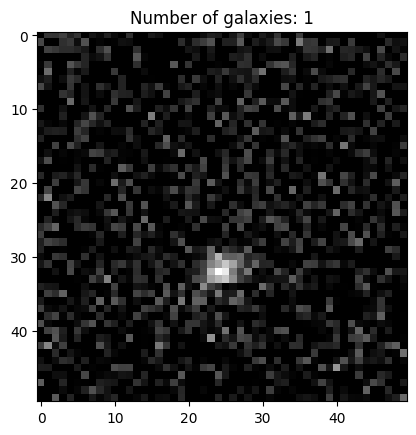

In [ ]:
i = np.random.randint(len(val_images))
plt.imshow(val_images[i].squeeze(), cmap='gray');
plt.title(f"Number of galaxies: {val_counts[i]}");

# Model architecture

input： image

output：the number of galaxies in the image

considering this as a classification problem, that is, the numbers will be treated as classes

In [1]:
# the image dimension
dim = 50
# the number of classes (maximum number of galaxies is 6)
n_classes = 7

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),  
    nn.BatchNorm2d(64),
    nn.ReLU(), 
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(128*3*3, 128),  
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 7)
)

# Training 

re-initializes function

In [ ]:
def reset_model_parameters(model):
    for module in model.modules():
        if hasattr(module, 'reset_parameters'):
            module.reset_parameters()

In [ ]:
def train(model, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=10):
    loss_fn = nn.CrossEntropyLoss()
    reset_model_parameters(model)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):

        train_loss = 0
        number = 0

        model.train()
        for images, counts in train_dataloader:
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, counts)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            number += images.size(0)

        epoch_loss = train_loss / number 

        val_loss = 0
        number0 = 0

        with torch.no_grad():
            model.eval()
            for images, counts in val_dataloader:
                outputs = model(images)
                loss = loss_fn(outputs, counts)
                val_loss += loss.item() * images.size(0)
                number0 += images.size(0)

        epoch_val_loss = val_loss / number0

        print(f"epoch:{epoch} train:{epoch_loss:.4f} val: {epoch_val_loss:.4f}")
        scheduler.step(epoch_val_loss)

        train_losses.append(epoch_loss)
        val_losses.append(epoch_val_loss)

    return train_losses, val_losses

In [ ]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [ ]:
# data loaders
from torchvision import transforms
import torch.nn.functional as F

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=180),   
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.RandomAffine(
        degrees=0, 
        translate=(0.1, 0.1), 
        scale=(0.8, 1.2)  
    ),
    transforms.ColorJitter(
        brightness=0.2, 
        contrast=0.2, 
        saturation=0.2,  
        hue=0.1         
    ),
    transforms.RandomResizedCrop(
        size=(50, 50),  
        scale=(0.8, 1.0), 
        ratio=(0.9, 1.1)
    ),
    transforms.RandomPerspective(
        distortion_scale=0.5, 
        p=0.5  
    ),
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))
])

class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, images, counts, augment=False):
        self.images = images
        self.counts = counts
        self.augment = augment
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].clone() 
        count = self.counts[idx]
        
        if self.augment:
            k = torch.randint(0, 4, (1,)).item()  
            if k > 0:
                image = torch.rot90(image, k, dims=[-2, -1])
            
            if torch.rand(1).item() > 0.5:
                image = torch.flip(image, dims=[-2]) 
            if torch.rand(1).item() > 0.5:
                image = torch.flip(image, dims=[-1])  
                
            if torch.rand(1).item() > 0.5:
                scale = 0.8 + 0.4 * torch.rand(1).item()  
                image = image * scale
                image = torch.clamp(image, 0, 1)  
        
        return image, count

In [ ]:
batch_size = 32

train_dataset = GalaxyDataset(train_images, train_counts, augment=True)
val_dataset = GalaxyDataset(val_images, val_counts, augment=False)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
train_losses, val_losses = train(model, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=75)

epoch:0 train:1.0749 val: 0.6353
epoch:1 train:0.7311 val: 0.4900
epoch:2 train:0.6502 val: 0.3708
epoch:3 train:0.6215 val: 0.3408
epoch:4 train:0.6043 val: 0.3630
epoch:5 train:0.5789 val: 0.3850
epoch:6 train:0.5564 val: 0.4072
epoch:7 train:0.5432 val: 0.4281
epoch:8 train:0.4955 val: 0.3060
epoch:9 train:0.4800 val: 0.2996
epoch:10 train:0.4638 val: 0.2865
epoch:11 train:0.4614 val: 0.2872
epoch:12 train:0.4576 val: 0.2819
epoch:13 train:0.4480 val: 0.2738
epoch:14 train:0.4437 val: 0.2982
epoch:15 train:0.4406 val: 0.3015
epoch:16 train:0.4361 val: 0.2703
epoch:17 train:0.4384 val: 0.2699
epoch:18 train:0.4297 val: 0.2726
epoch:19 train:0.4366 val: 0.2732
epoch:20 train:0.4210 val: 0.2749
epoch:21 train:0.4161 val: 0.2644
epoch:22 train:0.4111 val: 0.2806
epoch:23 train:0.4206 val: 0.2886
epoch:24 train:0.4176 val: 0.2670
epoch:25 train:0.4215 val: 0.2692
epoch:26 train:0.4013 val: 0.2631
epoch:27 train:0.3956 val: 0.2685
epoch:28 train:0.3997 val: 0.2653
epoch:29 train:0.4015 va

Plot of training and validation losses

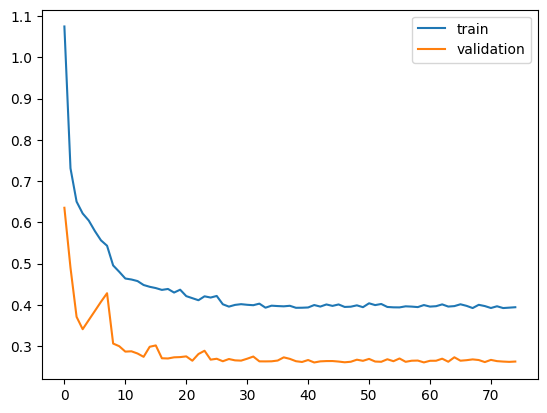

In [ ]:
plt.plot(train_losses, label='train');
plt.plot(val_losses, label='validation');
plt.legend();

# Evaluating the accuracy on the validation set

In [ ]:
model.eval()
pred_train_counts = model(train_images)
pred_val_counts = model(val_images)

In [ ]:
train_accuracy = (pred_train_counts.argmax(dim=1) == train_counts).float().mean().item()
val_accuracy = (pred_val_counts.argmax(dim=1) == val_counts).float().mean().item()
print(f"Train accuracy: {train_accuracy:.2f}")
print(f"Validation accuracy: {val_accuracy:.2f}")

Train accuracy: 0.89
Validation accuracy: 0.92


# Predicting on the test set

In [ ]:
test_images = torch.load(f"test_images_0.0125.pt")
test_images = test_images.unsqueeze(1)
test_loader = DataLoader(test_images, batch_size=512, shuffle=False, num_workers=2)

In [ ]:
predictions = []
model.eval()

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

image_ids = [f'{i}' for i in range(test_images.shape[0])]
prediction_df = pd.DataFrame({
    'id'   : image_ids,
    'label': predictions
})

prediction_df.to_csv('submission.csv', index=False)
